# Initialisation

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from torch_geometric.transforms import NormalizeFeatures

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

Dataframe_Labels = pd.read_csv("../../BLCA_DATA/Workspace/labels_str.csv")
Dataframe_link = pd.read_csv("../../BLCA_DATA/Workspace/patient_norm.csv")
Dataframe_node= pd.read_csv("../../BLCA_DATA/Workspace/node_embedding.csv")

Dataframe_Labels['class_int'], uniques = pd.factorize(Dataframe_Labels['class'])
Dataframe_Labels

,Patient,class,class_int
0,TCGA-2F-A9KO,LumP,0
1,TCGA-2F-A9KP,LumP,0
2,TCGA-2F-A9KQ,LumP,0
3,TCGA-2F-A9KR,Ba/Sq,1
4,TCGA-2F-A9KT,Ba/Sq,1
...,...,...,...
399,TCGA-ZF-AA56,Ba/Sq,1
400,TCGA-ZF-AA58,Ba/Sq,1
401,TCGA-ZF-AA5H,Ba/Sq,1
402,TCGA-ZF-AA5N,LumP,0


# Mise en place des arretes, noeuds et leur poids

### à améliorer, modification du treshold

In [2]:
node_features = Dataframe_node.drop(columns=['Patient']).values
node_features = torch.tensor(node_features, dtype=torch.float)

x = node_features
patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])
similarity_threshold = 0.5  # Exemple de seuil de similarité

edge_index = []
edge_attr = []

for i in range(patient_similarity.shape[0]):
    for j in range(i + 1, patient_similarity.shape[0]):
        if patient_similarity[i, j] > similarity_threshold:
            edge_index.append([i, j])
            edge_attr.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
        patient_similarity[i, i] = 0

edge_index = torch.tensor(edge_index, dtype=torch.int64).t().contiguous()
edge_features = torch.tensor(Dataframe_link.drop(columns=['Patient']).values, dtype=torch.float)
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

temporary_node_tab = Dataframe_Labels["class_int"].values
node_labels = torch.tensor(temporary_node_tab, dtype=torch.long)
node_labels

tensor([0, 0, 0, 1, 1, 2, 2, 3, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 2, 4,
        1, 1, 5, 1, 1, 1, 1, 1, 1, 0, 3, 3, 0, 1, 1, 2, 1, 5, 4, 1, 0, 1, 1, 0,
        1, 1, 5, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 1, 2, 1, 2, 0, 0, 1, 2, 4, 1, 3, 0,
        3, 4, 1, 1, 1, 4, 2, 1, 1, 3, 0, 4, 1, 2, 1, 1, 3, 0, 1, 0, 0, 2, 4, 1,
        0, 1, 1, 0, 1, 1, 1, 3, 2, 5, 0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0,
        0, 0, 0, 0, 0, 3, 2, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 2, 3, 3, 1, 1, 1, 3, 2, 1, 2, 2, 3, 3, 0, 1, 0, 3, 1, 1, 0, 3, 1, 3,
        3, 1, 1, 0, 1, 1, 4, 3, 3, 1, 0, 3, 3, 1, 4, 1, 2, 0, 2, 3, 0, 1, 0, 1,
        1, 0, 5, 0, 1, 1, 0, 2, 0, 1, 0, 2, 0, 1, 3, 0, 1, 0, 1, 1, 2, 1, 2, 4,
        4, 1, 1, 0, 2, 2, 1, 0, 1, 0, 1, 1, 0, 3, 2, 1, 4, 0, 2, 2, 0, 3, 2, 0,
        0, 1, 2, 0, 2, 0, 0, 2, 1, 1, 3, 4, 1, 1, 1, 0, 1, 1, 1, 1, 2, 3, 3, 0,
        0, 0, 2, 0, 2, 1, 2, 0, 2, 1, 1,

In [3]:
def count_classes_weights(tensor):
    array = tensor.numpy()
    N = np.shape(array)[0]
    classes_tab = [0, 0, 0, 0, 0, 0]
    for i in array:
        classes_tab[i]+=1

    mean_nb_classes = 0
    for i in classes_tab:
        mean_nb_classes += i
    mean_nb_classes *= 1/len(classes_tab)
    
    # normalize the weights
    weight_sum = 0
    for i in range(len(classes_tab)):
        weight_sum += mean_nb_classes / classes_tab[i]
    alpha = 1 / weight_sum

    weight_dict = {}
    for i in range(len(classes_tab)):
        weight_dict[i] = alpha * (mean_nb_classes / classes_tab[i]) *10
    return classes_tab, weight_dict

classes_tab, weight_dict = count_classes_weights(node_labels)

Dataframe_Labels['weight'] = [weight_dict[x] for x in Dataframe_Labels['class_int']]

node_weights = torch.tensor(Dataframe_Labels['weight'], dtype=torch.float)
node_weights


tensor([0.2893, 0.2893, 0.2893, 0.2401, 0.2401, 0.6932, 0.6932, 0.8165, 0.2893,
        0.2401, 0.6932, 0.2893, 0.2401, 0.2893, 0.6932, 0.2401, 0.2401, 0.2893,
        0.2401, 0.2401, 0.6932, 0.2893, 0.6932, 1.8371, 0.2401, 0.2401, 6.1237,
        0.2401, 0.2401, 0.2401, 0.2401, 0.2401, 0.2401, 0.2893, 0.8165, 0.8165,
        0.2893, 0.2401, 0.2401, 0.6932, 0.2401, 6.1237, 1.8371, 0.2401, 0.2893,
        0.2401, 0.2401, 0.2893, 0.2401, 0.2401, 6.1237, 0.2401, 0.2401, 0.2893,
        0.2401, 0.2893, 0.2401, 0.2893, 0.2893, 0.2893, 0.2893, 0.2893, 0.2893,
        0.2893, 0.2893, 0.2893, 0.2893, 0.2893, 0.2893, 0.2893, 0.2893, 0.2893,
        0.2893, 0.2893, 0.2893, 0.2893, 0.2893, 0.2401, 0.2893, 0.6932, 0.2401,
        0.6932, 0.2893, 0.2893, 0.2401, 0.6932, 0.2401, 0.6932, 0.2893, 0.2893,
        0.2401, 0.6932, 1.8371, 0.2401, 0.8165, 0.2893, 0.8165, 1.8371, 0.2401,
        0.2401, 0.2401, 1.8371, 0.6932, 0.2401, 0.2401, 0.8165, 0.2893, 1.8371,
        0.2401, 0.6932, 0.2401, 0.2401, 

# 1er GATv2 - Simple

### Définition des masques utilisés

In [4]:
def set_mask(start, length=0):
    mask = []
    for i in range(404):
        if i < start or i >= start + length :
            mask.append(False)
        else : 
            mask.append(True)
    return mask

In [5]:
# data on which the model will be trained
train_length = int(404 * 0.7)
train_mask = torch.tensor(set_mask(start=0, length=train_length), dtype=torch.bool)

length = int((404 - train_length) * 0.5)
val_mask = torch.tensor(set_mask(start=train_length, length=length), dtype=torch.bool)

test_mask = torch.tensor(set_mask(start=train_length + length, length=length), dtype=torch.bool)


### Définition de l'objet data utilisé

In [6]:
data1 = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=node_labels, weights = node_weights, num_classes=6, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
"""print(data1)

print(len(data1.y.tolist()))
print(data1.y.tolist())
print(data1.train_mask.tolist())
print(data1.y[data1.train_mask].tolist())
print(data1.y.tolist())
print(data1.test_mask.tolist())
print(data1.y[data1.test_mask].tolist())
print(data1.y.tolist())
print(data1.val_mask.tolist())
print(data1.y[data1.val_mask].tolist())

print(data1.x)
print(data1.edge_index)"""

'print(data1)\n\nprint(len(data1.y.tolist()))\nprint(data1.y.tolist())\nprint(data1.train_mask.tolist())\nprint(data1.y[data1.train_mask].tolist())\nprint(data1.y.tolist())\nprint(data1.test_mask.tolist())\nprint(data1.y[data1.test_mask].tolist())\nprint(data1.y.tolist())\nprint(data1.val_mask.tolist())\nprint(data1.y[data1.val_mask].tolist())\n\nprint(data1.x)\nprint(data1.edge_index)'

In [7]:
data = data1

In [8]:
class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1)

    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x
    

model = GATv2(hidden_channels=16, heads=8)
print(model)

# data on which the model will be trained
train_length = int(404 * 0.7)
data.train_mask = torch.tensor(set_mask(start=0, length=train_length), dtype=torch.bool)

length = int((404 - train_length) * 0.5)
data.val_mask = torch.tensor(set_mask(start=train_length, length=length), dtype=torch.bool)

data.test_mask = torch.tensor(set_mask(start=train_length + length, length=length), dtype=torch.bool)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():

    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    print("test", len(mask))
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    #print(f"out shape: {out.shape}")
    pred = out.argmax(dim=1)
    #print(pred[mask])
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc , pred

for epoch in range(1, 2):
    loss = train()
    val_acc = test(data.val_mask)[0]
    test_acc, pred = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val {val_acc:.4f}, Test {test_acc:.4f}')

GATv2(
  (conv1): GATv2Conv(825, 16, heads=8)
  (conv2): GATv2Conv(128, 6, heads=1)
)
test 404
test 404
Epoch: 001, Loss: 2.0898, Val 0.2623, Test 0.2951


In [9]:
print(data.y[data.test_mask])
print(pred[test_mask])

tensor([1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 0, 3, 1, 1, 2, 4, 0, 1, 0, 1, 1, 1, 1, 5,
        3, 0, 0, 1, 0, 1, 4, 0, 0, 0, 0, 0, 0, 3, 3, 1, 1, 1, 0, 0, 1, 1, 1, 2,
        0, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 3])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# 2eme GATv2 - Avec mise à jour des poids des classes

In [10]:
import random

test_index = random.sample(range(0, data.num_nodes), int(0.3 * data.num_nodes))
 
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test_index] = True

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

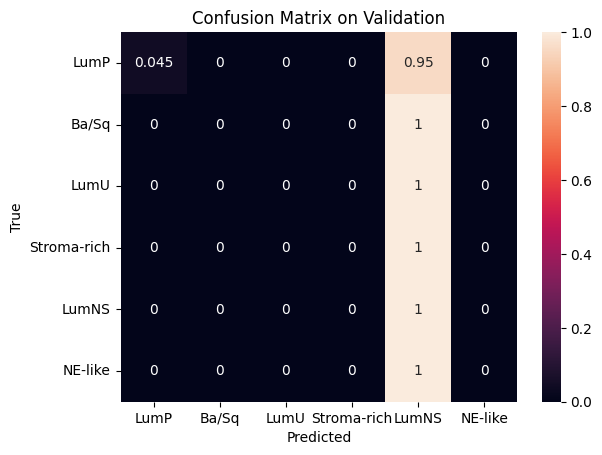

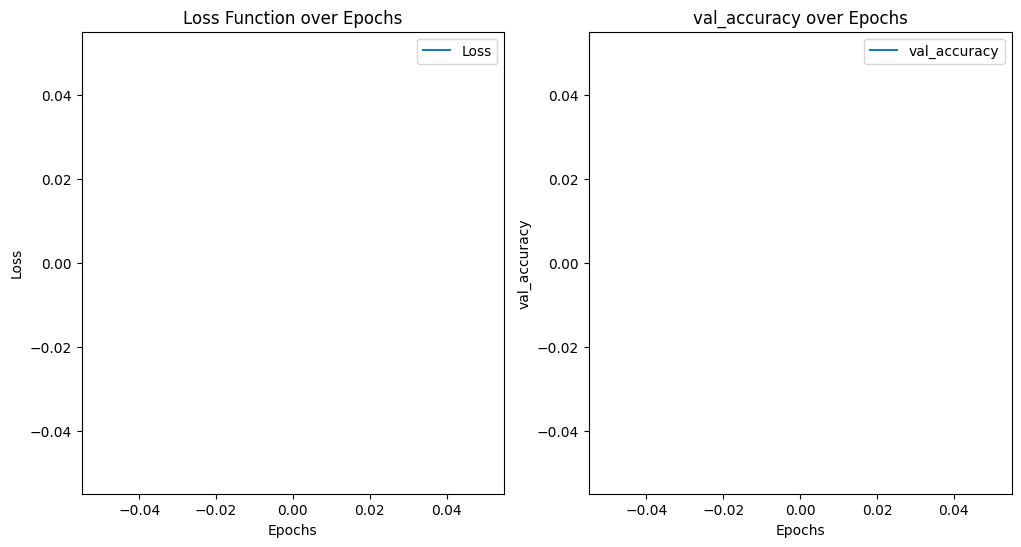

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

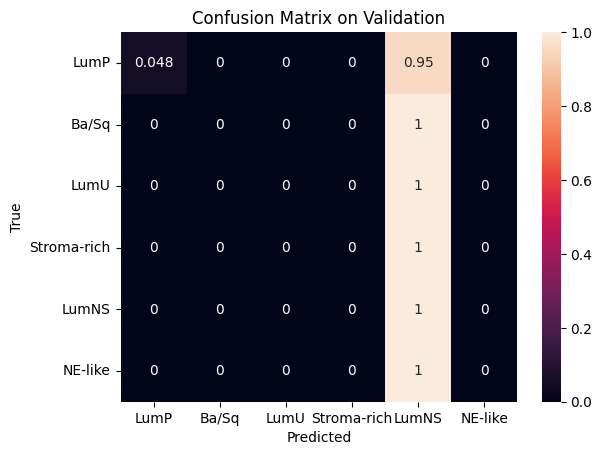

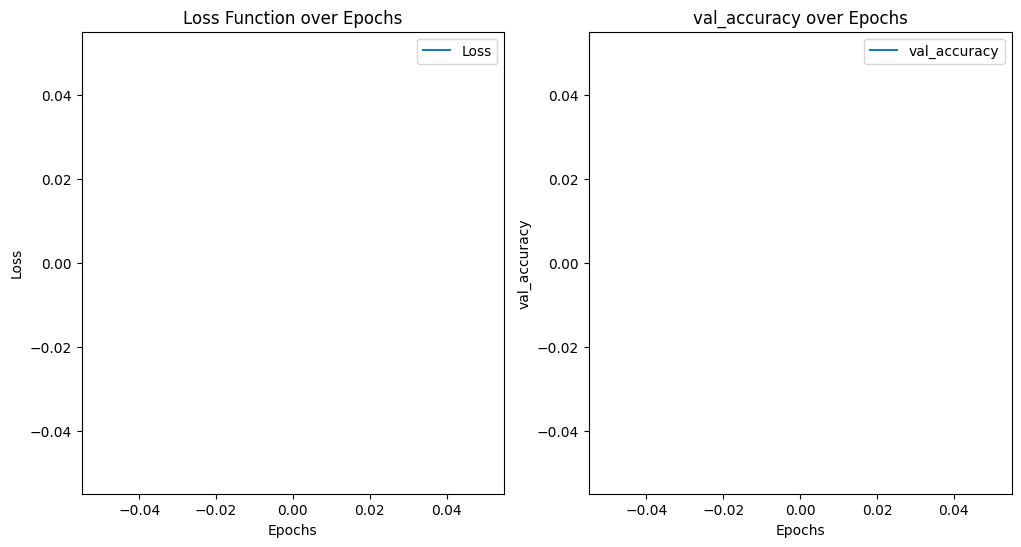

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

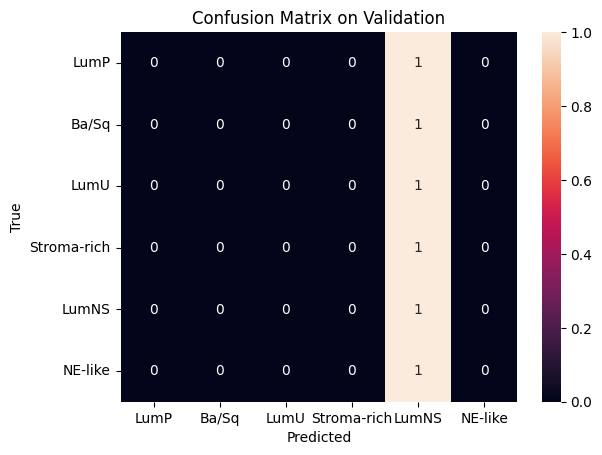

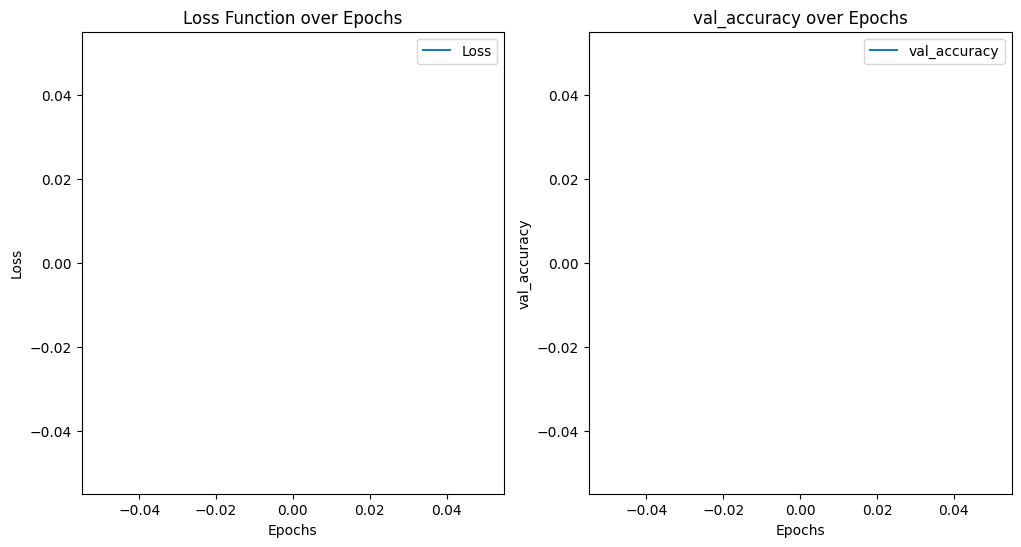

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

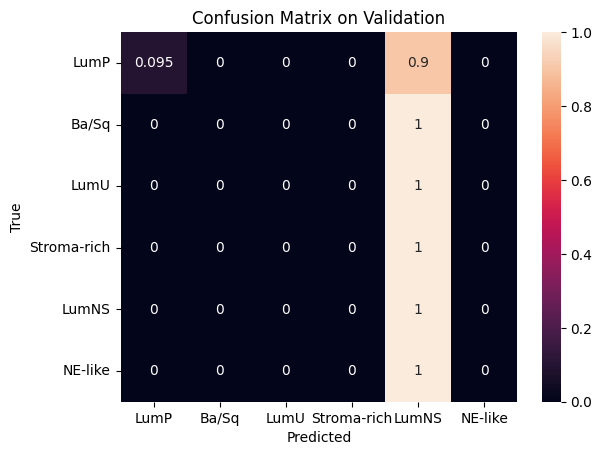

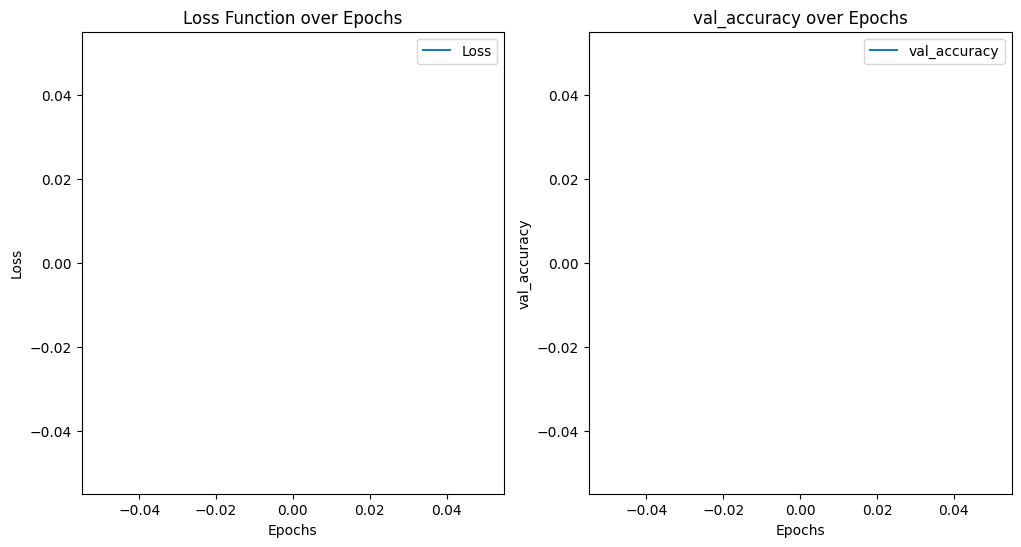

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

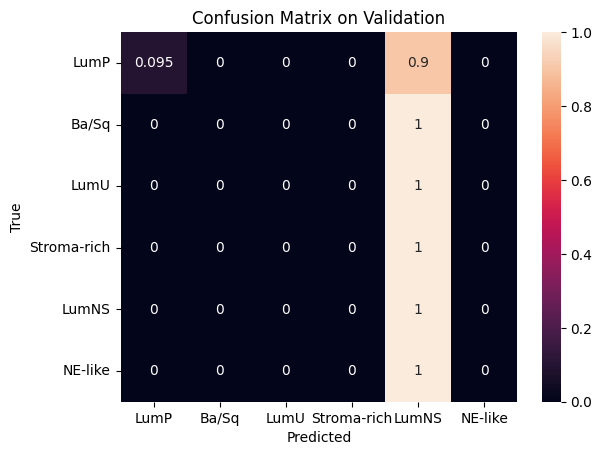

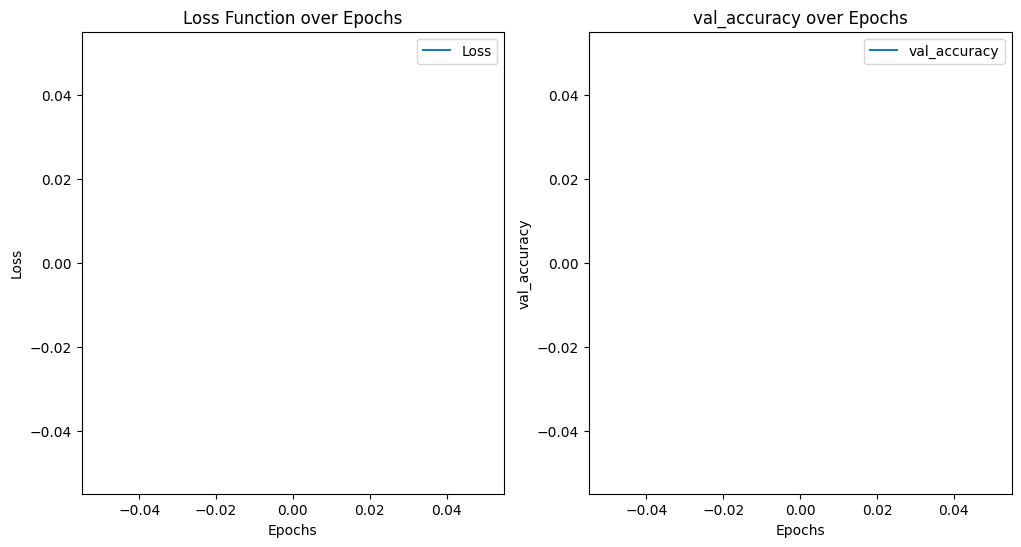

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

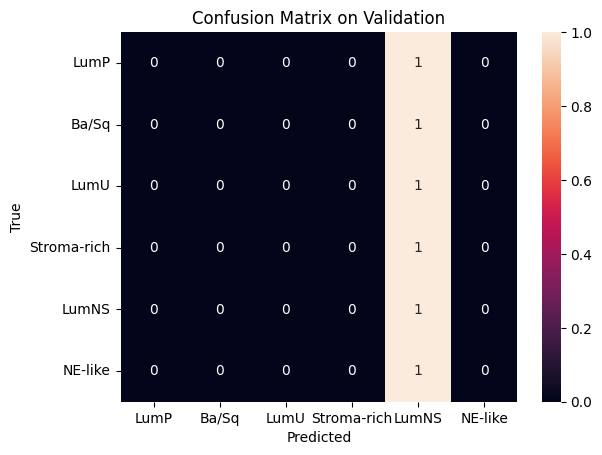

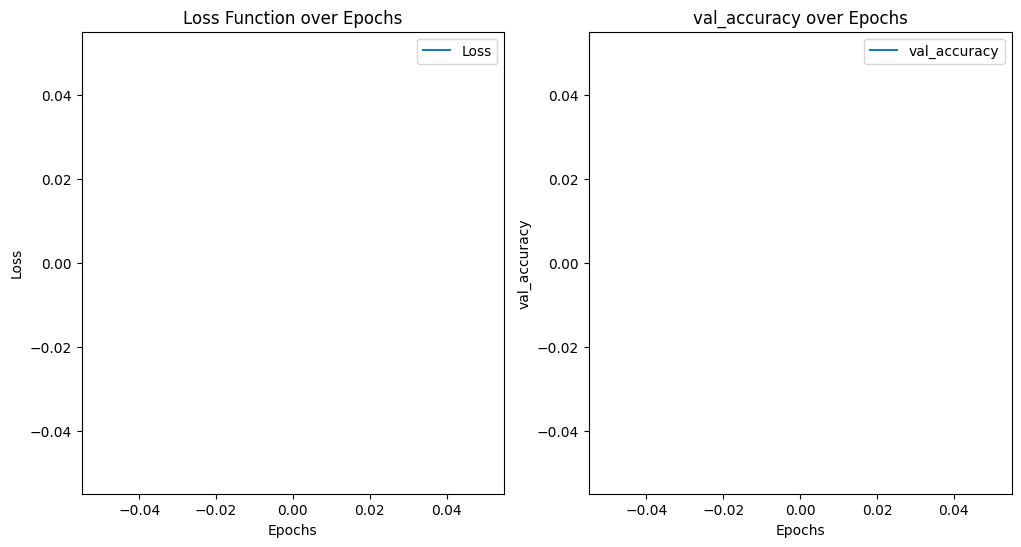

Mean Validation Accuracy: 0.0643, Std Validation Accuracy: 0.0138


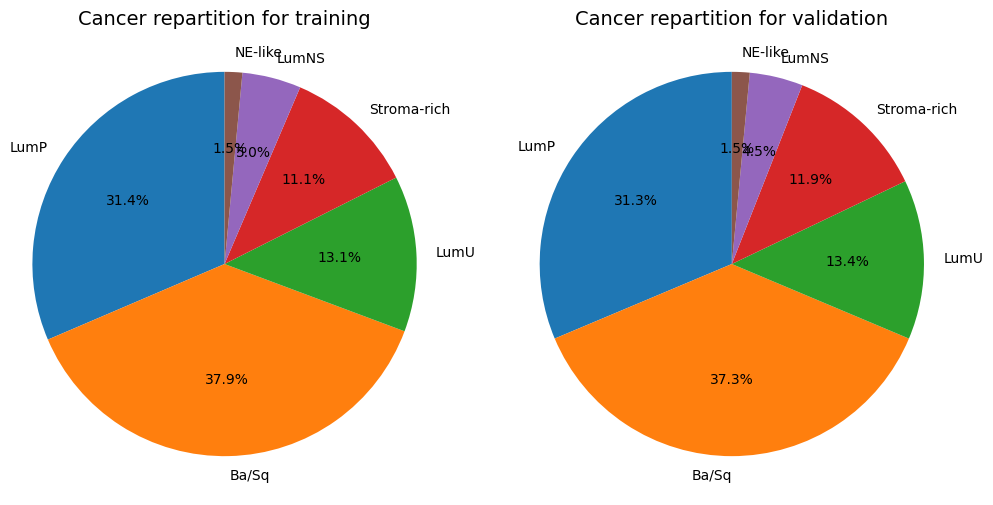

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sn

class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1)
        
    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x

def weighted_cross_entropy_loss(output, target, weights):
    loss = F.cross_entropy(output, target, reduction='none')
    weighted_loss = loss * weights[target]
    return weighted_loss.mean()

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = weighted_cross_entropy_loss(out[data.train_mask], data.y[data.train_mask], data.weights[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, model


def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask]

def cross_validation(data, k_folds, hidden_channels, heads, num_epochs=1):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1234)
    all_val_acc = []

    val_acc_best = 0

    for fold, (_, val_index) in enumerate(skf.split(data.x, data.y)):
        # Define masks
        train_index = [i for i in range(data.num_nodes)]
        print(train_index)

        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[train_index] = True
        
        print(len(val_index))
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask[val_index] = True
        
        train_classes, _ = count_classes_weights(data.y[data.train_mask])
        val_classes, _ = count_classes_weights(data.y[data.val_mask])

        # Initialize model, optimizer, and loss function
        model = GATv2(hidden_channels=hidden_channels, heads=heads)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        lost_function_compil = []
        all_val_acc_plot = []

        # Training loop
        for epoch in range(1, num_epochs):
            loss, model = train(model, data, optimizer)
            train_acc, _ =test (model, data, data.train_mask)
            val_acc, _ = test(model, data, data.val_mask)
            lost_function_compil.append(loss.detach().tolist())
            all_val_acc_plot.append(val_acc)

            print(f'Fold: {fold + 1}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Train_acc {train_acc:.4f}, Val_acc {val_acc:.4f}')

        # Evaluate on validation set
        val_acc, y_pred = test(model, data, data.val_mask)
        y_true = data.y[data.val_mask]

        # Store results
        all_val_acc.append(val_acc)
        conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())

        if val_acc > val_acc_best:
            best_model = model

        # Plot confusion matrix
        classes = ('LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like')
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        df_cm = pd.DataFrame(conf_matrix_normalized, index=classes, columns=classes)  
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix on Validation')
        plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.plot(range(len(lost_function_compil)), lost_function_compil, label='Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Function over Epochs')
        ax1.legend()

        ax2.plot(range(len(all_val_acc_plot)), all_val_acc_plot, label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('val_accuracy')
        ax2.set_title('val_accuracy over Epochs')
        ax2.legend()

        plt.show()

    # Calculate and print overall metrics
    mean_val_acc = np.mean(all_val_acc)
    std_val_acc = np.std(all_val_acc)
    print(f'Mean Validation Accuracy: {mean_val_acc:.4f}, Std Validation Accuracy: {std_val_acc:.4f}')

    return train_classes, val_classes, best_model
    
train_classes, val_classes, best_model = cross_validation(data, k_folds=6, hidden_channels=20, heads=8)

labels=['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(train_classes, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
ax1.set_title('Cancer repartition for training', fontsize=14)

ax2.pie(val_classes, labels=labels, startangle=90, autopct='%1.1f%%')
ax2.axis('equal')
ax2.set_title('Cancer repartition for validation', fontsize=14)

plt.show()

tensor([False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True,  True, False,
        False, False, False,  True, False, False,  True,  True,  True, False,
        False, False, False, False,  True,  True,  True, False, False,  True,
        False,  True,  True, False, False,  True,  True, False, False,  True,
         True,  True,  True, False, False, False, False, False, False, False,
        False,  True, False,  True, False, False, False,  True,  True,  True,
         True, False, False, False, False,  True, False, False, False, False,
         True, False, False, False, False, False, False, False, False,  True,
        False, False,  True, False, False,  True,  True, False, False,  True,
         True, False, False, False, False, False,  True, False, False,  True,
         True, False, False, False, False, False, False,  True, False,  True,
        False, False,  True,  True, False,  True, False,  True, 

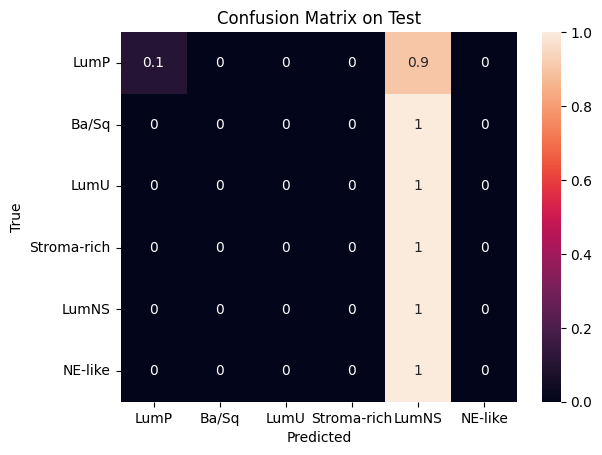

In [12]:
test_acc, y_pred = test(best_model, data, data.test_mask)
y_true = data.y[data.test_mask]

print(data.test_mask)


conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())

print(f'Test accuracy: {test_acc:.4f}')

classes = ('LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like')
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_matrix_normalized, index=classes, columns=classes)  
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test')
plt.show()